In [ ]:
from langgraph_agent import *

from IPython.display import Image, display
def visualize_graph(graph, fname="figs/agentic_graph.png"):
    try:
        png_bytes = graph.get_graph().draw_mermaid_png()
        display(Image(png_bytes))
        with open(fname, "wb") as f:
            f.write(png_bytes)
    except Exception as e:
        print(e)

## Testing Code

In [10]:
results = {}
selected_qid = '338'

question_data = [e for e in egolife_qa_jake if e['ID'] == selected_qid][0]

vqa_question = question_data['question']
options = f"""A.{question_data['choice_a']}\nB.{question_data['choice_b']}\nC.{question_data['choice_c']}\nD.{question_data['choice_d']}"""
answer = question_data['answer']
query_time = question_data['query_time']
target_day = question_data['target_time']['date'].upper()
subtitles = subtitles_dict[target_day]
num_video_frames, image_paths = get_50_frames_from_video(f'{frames_dir}/{target_day}/')
vidstart = image_paths[0].split("/")[-1][:4]
vidend = image_paths[-1].split("/")[-1][:4]

print(query_time)
print(vqa_question)
print(options)
print(f"Answer: {answer}\n")

{'date': 'DAY5', 'time': '12213913'}
What do I usually do after finishing in the kitchen?
A.Wipe with paper
B.Wash hands with dish soap
C.Wash hands with hand sanitizer
D.Wipe hands with a wet wipe
Answer: C



In [ ]:
value = run_agentic_inference(vqa_question, options, num_video_frames, vidstart, vidend, subtitles, target_day)

results['ID'] = selected_qid
results['question'] = vqa_question
results['options'] = options
results['answer'] = answer
results['plan'] = value["plan"]
results['plan_relevant_context'] = value['plan_relevant_context']
results['mcq_prediction'] = value["answer"].mcq_prediction
results['justification'] = value["answer"].justification
print(results)

## BM 25 experiment

In [18]:
df_transcript_all_days = get_egolife_dt_dataframe()
df_transcript_all_days['start_t'] = df_transcript_all_days['start_t'].str.replace(r',\d{1,3}', '', regex=True) # remove milliseconds
df_transcript_all_days['end_t'] = df_transcript_all_days['end_t'].str.replace(r',\d{1,3}', '', regex=True)
df_transcript_all_days["dt_english_timestamp"] = df_transcript_all_days.apply(
    lambda row: f"Day {row.day} from {row.start_t} to {row.end_t} - '{row.transcript_english}'",
    axis=1
)

In [19]:
print(df_transcript_all_days.iloc[:5])

   day   start_t     end_t transcript_chinese  \
0    1  11:09:47  11:09:50      Jake: 好然后一个秒表   
1    1  11:09:54  11:09:55       Shure:  时间戳呗   
2    1  11:09:56  11:09:56        Jake: 对 戳一下   
3    1  11:10:00  11:10:01        Jake: 来都戳一下   
4    1  11:10:01  11:10:02        Jake: 每人戳一下   

                      transcript_english  \
0  Jake: Okay, then we need a stopwatch.   
1        Shure: Mark a timestamp, right?   
2                    Jake: Yes, mark it.   
3       Jake: Come on, everyone mark it.   
4            Jake: Each person marks it.   

                                dt_english_timestamp  
0  Day 1 from 11:09:47 to 11:09:50 - 'Jake: Okay,...  
1  Day 1 from 11:09:54 to 11:09:55 - 'Shure: Mark...  
2  Day 1 from 11:09:56 to 11:09:56 - 'Jake: Yes, ...  
3  Day 1 from 11:10:00 to 11:10:01 - 'Jake: Come ...  
4  Day 1 from 11:10:01 to 11:10:02 - 'Jake: Each ...  


In [20]:
current_day = int(query_time['date'][3])
all_previous_days = [i+1 for i in range(current_day - 1)]
print(all_previous_days)
print(current_day)
# take all times on previous days
df_previous_days = df_transcript_all_days.loc[df_transcript_all_days['day'].isin(all_previous_days), 'dt_english_timestamp'].values
print(len(df_previous_days))

# take only up to query_time on current day
cutoff_time = timeformatter(query_time['time'])[:-3]
cutoff_dt = pd.to_datetime(cutoff_time, format="%H:%M:%S").time()
df_transcript_all_days['start_t_dt'] = pd.to_datetime(df_transcript_all_days['start_t'], format="%H:%M:%S").dt.time
df_current_day = df_transcript_all_days[
    (df_transcript_all_days['day'] == current_day) &
    (df_transcript_all_days['start_t_dt'] < cutoff_dt)
]['dt_english_timestamp'].values
print(len(df_current_day))

eng_transcripts_to_search = list(df_previous_days) + list(df_current_day)
print(len(eng_transcripts_to_search))

[1, 2, 3, 4]
5
32748
1171
33919


In [74]:
import bm25s

# Create your corpus here
corpus = [
    "a cat is a feline and likes to purr",
    "a dog is the human's best friend and loves to play",
    "a bird is a beautiful animal that can fly",
    "a fish is a creature that lives in water and swims",
]

# Create the BM25 model and index the corpus
retriever = bm25s.BM25(corpus=corpus)
retriever.index(bm25s.tokenize(corpus)) 

# Query the corpus and get top-k results
query = "What does a dog do different from a bird?"
results, scores = retriever.retrieve(bm25s.tokenize(query), k=2)

# Let's see what we got!
doc, score = results[0, 0], scores[0, 0]
# print(f"Rank {i+1} (score: {score:.2f}): {doc}")
print(doc, score)

Split strings:   0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/4 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/4 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

a bird is a beautiful animal that can fly 0.48158914


In [87]:
import bm25s
corpus = eng_transcripts_to_search
retriever = bm25s.BM25() # pass corpus=corpus arg to return docs instead of doc IDs
retriever.index(bm25s.tokenize(corpus)) # takes ~400ms to tokenize and index for day 7

Split strings:   0%|          | 0/33979 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/33979 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/33979 [00:00<?, ?it/s]

In [91]:
%%time
query = vqa_question
results, scores = retriever.retrieve(bm25s.tokenize(query), k=50) # ~ 15ms search time
# for i in results[0]:
#     print(corpus[i])
# print(results[0])
# print(scores[0])

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 13.5 ms, sys: 5.34 ms, total: 18.8 ms
Wall time: 16.4 ms


## Agent Accuracy + Plotting

In [27]:
import glob
import json

dataset = 'egolife' # egolife, videomme
agent_backbone = 'gpt-4.1' # gpt-4.1, gemini-2.5-pro, qwen-2.5-vl-7b
# fname = f'agent_{agent_backbone}/egolife_agentic_entitygraph+dt+visual_results' # egolife_agentic_entitygraph_oracledayvisual_results
# fname = f'{dataset}_agentic-{agent_backbone}_visual+entitygraph-dtonly-and-dtcaptionfuse+dt-llmsearch_results' # egolife_agentic_entitygraph_oracledayvisual_results
# fname = f'{dataset}_agentic-{agent_backbone}_visual+entitygraph-dtonly-and-dtcaptionfuse+dt-oracleday_results' # egolife_agentic_entitygraph_oracledayvisual_results

# fname = 'egolife_agentic-gpt-4.1_visual-only_results'
# fname = 'egolife_agentic-gpt-4.1_entitygraph-t+c-only_results'
fname = 'egolife_agentic-gpt-4.1_visual+entitygraph-t+c_results'

merged_json = []
for batch_json in glob.glob(f'{fname}_start*'):
    with open(batch_json, 'r') as file:
        try:
            data = json.load(file)
            merged_json.extend(data)  # Add the list of dictionaries to merged_data
        except Exception as e:
            print(batch_json)
            print(e)

with open(f'egolife_results/agent_{agent_backbone}/{fname}.json', 'w') as output_file:
    json.dump(merged_json, output_file, ensure_ascii=False, indent=4)

In [28]:
print(merged_json[0].keys())

dict_keys(['ID', 'question', 'options', 'answer', 'plan', 'plan_relevant_context', 'mcq_prediction', 'justification', 'total_tokens'])


In [29]:
print_acc(dataset, agent_backbone, 'EG-TC + F + T', merged_json)
agent_gpt41_egft = get_eg_f_t_agent_results('gpt-4.1')
print_acc(dataset, agent_backbone, 'EG-TC + F + T', agent_gpt41_egft)

egolife: gpt-4.1 with EG-TC + F + T, Acc = 182 / 500 =  36.40%
egolife: gpt-4.1 with EG-TC + F + T, Acc = 199 / 369 =  53.93%


In [55]:
with open(f'egolife_results/diarized_transcripts/prevDTdays-4/mcq_english/gpt-4.1_DTlang-english_removediarization-False_egolife_results.json', 'r') as f:
    final_prediction_list = json.load(f)
    
for entry in final_prediction_list:
    qid = entry['ID']
    question_data = [e for e in egolife_qa_jake if e['ID'] == qid][0]
    mcq_pred = extract_mcq_prediction(entry['content'].strip("```json").strip("response :\n"))
    answer = question_data['answer']
    entry['answer'] = answer
    entry['mcq_prediction'] = mcq_pred
    entry['type'] = question_data['type']

print_acc(dataset, agent_backbone, 'T', final_prediction_list)

egolife: gpt-4.1 with T, Acc = 228 / 500 =  45.60%


In [53]:
df_results = pd.DataFrame(final_prediction_list)
df_results['is_correct'] = (df_results['answer'] == df_results['mcq_prediction']) * 100
acc_results = df_results.groupby(['type'])['is_correct'].mean().reset_index()
print(acc_results)

           type  is_correct
0     EntityLog   32.800000
1   EventRecall   42.857143
2  HabitInsight   59.016393
3   RelationMap   44.000000
4    TaskMaster   66.666667


### Eval + Plot

In [85]:
from run_simple_baselines import split_entry, convert_singlet_to_list

with open("/source/data/aniketr/EgoLife/EgoLifeQA/EgoLifeQA_A1_JAKE.json", "r", encoding="utf-8") as f:
    egolife_qa_jake = json.load(f)
    
multiple_target_time = []
for e in egolife_qa_jake:
    tt = e['target_time']
    if isinstance(tt, dict):
        if'time' not in tt.keys():
            e['target_time'] = [tt]
        else:
            if len(tt['time']) > 8:
                e['target_time'] = split_entry(tt)
            else:
                e['target_time'] = convert_singlet_to_list(tt)

subtitles_dict = get_egolife_diarized_transcripts(remove_diarization=False)

In [5]:
def count_tokens(results):
    tokens = [e['total_tokens'] for e in results if 'total_tokens' in e.keys()]
    return tokens

def print_acc(dataset, agent_backbone, config, results):
    correct = [e for e in results if e['answer'] == e['mcq_prediction']]
    print(f'{dataset}: {agent_backbone} with {config}, Acc = {len(correct)} / {len(results)} = {len(correct) / len(results) * 100: .2f}%')

def get_eg_f_t_agent_results(agent_backbone = 'gpt-4.1'):
    results_json = f'egolife_results/agent_{agent_backbone}/egolife_agentic-{agent_backbone}_visual+entitygraph-dtonly-and-dtcaptionfuse+dt-oracleday_results.json' 
    with open(results_json, 'r') as file:
        agent_results = json.load(file)
    return agent_results

dataset = 'egolife'
agent_backbone = 'gpt-4.1'
results_json = f'egolife_results/agent_{agent_backbone}/egolife_agentic_oracleday-visual_notimefilter_results.json' 
with open(results_json, 'r') as file:
    agent_gpt41_ft = json.load(file)
print_acc(dataset, 'gpt-4.1', "F + T", agent_gpt41_ft)

results_json = f'egolife_results/agent_{agent_backbone}/egolife_agentic-{agent_backbone}_visual+entitygraph+dt-oracleday_results.json' 
with open(results_json, 'r') as file:
    agent_gpt41_egft = json.load(file)
print_acc(dataset, 'gpt-4.1', "EG + F + T", agent_gpt41_egft)

agent_gpt4o_egft = get_eg_f_t_agent_results('gpt-4o')
agent_gemini25_egft = get_eg_f_t_agent_results('gemini-2.5-pro')
print_acc(dataset, 'gpt-4o', 'EG-TC + F + T', agent_gpt4o_egft)
print_acc(dataset, 'gemini-2.5-pro', 'EG-TC + F + T', agent_gemini25_egft)

egolife: gpt-4.1 with F + T, Acc = 244 / 500 =  48.80%
egolife: gpt-4.1 with EG + F + T, Acc = 260 / 500 =  52.00%
egolife: gpt-4o with EG-TC + F + T, Acc = 255 / 500 =  51.00%
egolife: gemini-2.5-pro with EG-TC + F + T, Acc = 300 / 497 =  60.36%


In [10]:
results_json = 'egolife_results/captions/mcq_english/gpt-4.1_mcq-english_captioner-gpt-4.1_summarized_useDT-False_useDToracle-False_prevDTdays-0_removediarization-False_egolife_results.json'
with open(results_json, 'r') as file:
    gpt41_caption_llm = json.load(file)

results_gpt41_caption = []

for entry in gpt41_caption_llm:
    results = {}
    qid = entry['ID']
    question_data = [e for e in egolife_qa_jake if e['ID'] == qid][0]
    mcq_pred = extract_mcq_prediction(entry['content'].strip("```json").strip("response :\n"))
    answer = question_data['answer']
    
    results['ID'] = qid
    results['answer'] = answer
    results['mcq_prediction'] = mcq_pred
    results['total_token_count'] = entry['response_metadata']['token_usage']['total_tokens']
    results_gpt41_caption.append(results)

In [30]:
with open(f'egolife_results/agent_{agent_backbone}/{fname}.json', 'r') as file:
    agent_results = json.load(file)
tokens_all_mcq = count_tokens(agent_results)
token_sum = []
print(len(agent_results))
for mcq in tokens_all_mcq:
    tokens_used_for_mcq = [list(e.values())[0] for e in mcq]
    token_sum.append(np.sum(tokens_used_for_mcq))

print(f'Average # Tokens used = {np.average(token_sum)/1000 : .0f}K')

500
Average # Tokens used =  143K


In [14]:
# print(agent_gpt4o_egft[0])

In [83]:
import glob
import json
import pandas as pd 

mllm_baseline = f'egolife_results/gemini-2.5-pro-uniform-sample-frames+dt-3000.json'
with open(mllm_baseline, 'r') as file:
    results_mllm_baseline = json.load(file)

df_egolife = pd.DataFrame(egolife_qa_jake)

In [10]:
print(json.loads(results_mllm_baseline[0]['response']['candidates'][0]['content']['parts'][0]['text'][7:-3])[0]['justification'])

Alice is the first person to explicitly state that she has used the screwdriver. In the transcript at 11:17:09:09, Alice says, "I've already screwed in one screw." This occurs before anyone else is mentioned or seen using the screwdriver. Although Tasha is later seen using it around 11:18:13:09, Alice's statement confirms she used it first.


In [11]:
# print(results_mllm_baseline[0])

correct = 0
total = 0
misformatted_qids = [9,36,42,62,70,75,81,95,104,115,144,267,282,324,325,359,363,387,395,404,410,421,432,436]
total_token_count = []

results_gemini25_uniformsample = []

for i in range(len(results_mllm_baseline)):
    results = {}
    qid = int(results_mllm_baseline[i]['key'].split("-")[-1])
    answer = egolife_qa_jake[qid-1]['answer']
    try:
        entry = [e for e in results_mllm_baseline if int(e['key'].split("-")[-1]) == (qid)][0]
        if qid in [e+1 for e in misformatted_qids]:
            mcq_pred = json.loads(entry['response']['candidates'][0]['content']['parts'][0]['text'][7:-3])['response'][0]['mcq_prediction']
            just = json.loads(entry['response']['candidates'][0]['content']['parts'][0]['text'][7:-3])['response'][0]['justification']
        else:
            mcq_pred = json.loads(entry['response']['candidates'][0]['content']['parts'][0]['text'][7:-3])[0]['mcq_prediction']
            just = json.loads(entry['response']['candidates'][0]['content']['parts'][0]['text'][7:-3])[0]['justification']

        results['ID'] = egolife_qa_jake[qid-1]['ID']
        results['answer'] = answer
        results['mcq_prediction'] = mcq_pred
        results['total_token_count'] = entry['response']['usageMetadata']['totalTokenCount']
        results['just'] = just
        results_gemini25_uniformsample.append(results)
        correct += mcq_pred == answer
        total += 1
        total_token_count.append(entry['response']['usageMetadata']['totalTokenCount'])
    except Exception as e:
        print(qid, e)

print(f'Acc = {(correct)} / {len(results_mllm_baseline)} = {(correct) / len(results_mllm_baseline) * 100: .2f}%')
print(total)

69 'parts'
Acc = 234 / 500 =  46.80%
499


In [ ]:
egobutler_gemini15pro_accuracy = {'EntityLog': 36.0, 'EventRecall': 37.3, 'HabitInsight': 45.9, 'RelationMap':30.4, 'TaskMaster':34.9}

def plot_category_wise_bars(results, results_gemini25_uniformsample):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    df_results = pd.DataFrame(results)
    df_uniform = pd.DataFrame(results_gemini25_uniformsample)
    df_qa = pd.DataFrame(egolife_qa_jake)
    
    # --- Step 2. Merge each with question type ---
    df_results = pd.merge(df_results, df_qa[['ID', 'type']], on='ID', how='inner')
    df_uniform = pd.merge(df_uniform, df_qa[['ID', 'type']], on='ID', how='inner')
    
    # --- Step 3. Compute accuracy for both Gemini 2.5 variants ---
    for df, label in [(df_results, 'Gemini 2.5 Pro EG Agent'),
                      (df_uniform, 'Gemini 2.5 Pro (Uniform Sample)')]:
        df['is_correct'] = df['answer'] == df['mcq_prediction']
        df['Model'] = label
        df['accuracy'] = df['is_correct'] * 100  # percent
    
    # --- Step 4. Compute per-type accuracy for each ---
    acc_results = df_results.groupby(['type', 'Model'])['accuracy'].mean().reset_index()
    acc_uniform = df_uniform.groupby(['type', 'Model'])['accuracy'].mean().reset_index()
    
    # --- Step 5. Add EgoButler (Gemini 1.5 Pro) baseline ---
    df_egobutler = pd.DataFrame([
        {'type': k, 'accuracy': v, 'Model': 'EgoButler (Gemini 1.5 Pro)'}
        for k, v in egobutler_gemini15pro_accuracy.items()
    ])
    
    # --- Step 6. Combine all three sources ---
    df_plot = pd.concat([acc_results, acc_uniform, df_egobutler], ignore_index=True)
    
    # --- Step 7. Plot grouped bars ---
    plt.figure(figsize=(9, 5))
    ax = sns.barplot(
        data=df_plot,
        x='type',
        y='accuracy',
        hue='Model',
        palette='Set2'
    )

    # --- Step 7. Annotate accuracy values above bars ---
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', label_type='edge', padding=3, fontsize=12)
    
    # --- Step 8. Aesthetics ---
    # plt.title('EgoLife Accura per Question Type')
    plt.ylabel('Accuracy (%)', fontsize=18)
    plt.xlabel('', fontsize=18)
    plt.ylim(0, 100)
    plt.legend(title='', loc='upper left', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=16)
    # plt.xticks(rotation=0, ha='right', fontsize=16)
    plt.tight_layout()
    plt.savefig('figs/category_wise_barplot.png')
    plt.show()

plot_category_wise_bars(final_prediction_list, results_gemini25_uniformsample)

In [22]:
import numpy as np
print(np.average(total_token_count))

806954.9799599198


In [23]:
test_idx = 9
print((results_mllm_baseline[test_idx]['response']['usageMetadata']['totalTokenCount']))
print(egolife_qa_jake[test_idx])
print(egolife_qa_jake[test_idx]['answer'])

806008
{'ID': '10', 'query_time': {'date': 'DAY1', 'time': '12172718'}, 'type': 'EntityLog', 'type_chinese': '实体日志', 'need_audio': False, 'need_name': True, 'last_time': False, 'trigger': 'The whiteboard in the meeting room is filled with meeting notes', 'trigger_chinese': '会议室的白板上写满了会议记录', 'question': 'Who was the first to write the meeting notes on the whiteboard in the meeting room?', 'question_chinese': '会议室白板上的会议记录谁最先写的？', 'choice_a': 'Shure', 'choice_a_chinese': 'Shure', 'choice_b': 'Alice', 'choice_b_chinese': 'Alice', 'choice_c': 'Katrina', 'choice_c_chinese': 'Katrina', 'choice_d': 'Me', 'choice_d_chinese': '我', 'answer': 'A', 'target_time': {'date': 'DAY1', 'time': '11264208'}, 'keywords': 'write meeting notes', 'reason': 'I saw Shure writing on the whiteboard', 'reason_chinese': '我看见Shure在白板上写字'}
A


### qualitative example

In [24]:
import pandas as pd

## examples where agent worked and uniform sampling failed

df_results = pd.DataFrame(agent_gemini25_egft)
df_uniform = pd.DataFrame(results_gemini25_uniformsample)
df_qa = pd.DataFrame(egolife_qa_jake)

# Add question types
df_results = pd.merge(df_results, df_qa[['ID', 'type']], on='ID', how='inner')
df_uniform = pd.merge(df_uniform, df_qa[['ID', 'type']], on='ID', how='inner')

# Compute correctness for each model
df_results['correct_25pro'] = df_results['answer'] == df_results['mcq_prediction']
df_uniform['correct_25uniform'] = df_uniform['answer'] == df_uniform['mcq_prediction']

# Merge both result sets on ID (and optionally on type)
df_compare = pd.merge(
    df_results[['ID', 'type', 'question', 'answer', 'mcq_prediction', 'correct_25pro']],
    df_uniform[['ID', 'mcq_prediction', 'correct_25uniform']],
    on='ID',
    suffixes=('_25pro', '_25uniform')
)

# Filter: relationmap type, Pro correct, Uniform wrong
df_diff = df_compare[
    (df_compare['type'].str.lower() == 'relationmap') &
    (df_compare['correct_25pro']) &
    (~df_compare['correct_25uniform'])
]

# Show results
df_diff = df_diff.reset_index(drop=True)
df_diff

,ID,type,question,answer,mcq_prediction_25pro,correct_25pro,mcq_prediction_25uniform,correct_25uniform
0,202,RelationMap,Who was next to me the last time I was throwin...,D,D,True,A,False
1,234,RelationMap,"When in the arcade, who watched Lucia play the...",C,C,True,A,False
2,236,RelationMap,"On the evening, we are going to have a barbecu...",D,D,True,A,False
3,263,RelationMap,Who navigated and led us all to Hema Fresh?,C,C,True,A,False
4,291,RelationMap,Who played the game with Tasha last time?,D,D,True,A,False
5,292,RelationMap,"Now we are preparing to move the table, who he...",B,B,True,A,False
6,256,RelationMap,"On the first day, who did Tasha ask to bring h...",D,D,True,A,False
7,275,RelationMap,Who was next to me the last time I made coffee?,D,D,True,A,False
8,404,RelationMap,Who among us has drunk Douzhi?,D,D,True,A,False
9,420,RelationMap,Who is sitting with Alice and making gestures ...,C,C,True,A,False


In [35]:
def print_agent_results_for_idx(idx):
    selected_qid = df_diff.iloc[idx]['ID']
    question_data = [e for e in egolife_qa_jake if e['ID'] == selected_qid][0]
    
    question = question_data['question']
    options = f"""
    A.{question_data['choice_a']}, B.{question_data['choice_b']}, C.{question_data['choice_c']}, D.{question_data['choice_d']}
    """
    answer = question_data['answer']
    query_time = question_data['query_time']
    
    print(selected_qid, question)
    print(options)
    print(answer)
    print(f"Query Time: {timeformatter(query_time['time'])[:-3]} on {query_time['date']}")
    print("GT Target Time: ", question_data["target_time"])
    plan = [e['plan'] for e in agent_gemini25_egft if e['ID'] == selected_qid][0]
    agent_resp = [e['justification'] for e in agent_gemini25_egft if e['ID'] == selected_qid][0]
    mllm_resp = [e['just'] for e in results_gemini25_uniformsample if e['ID'] == selected_qid][0]
    raw_memory = [e['plan_relevant_context'] for e in agent_gemini25_egft if e['ID'] == selected_qid][0]
    
    print('\n******************************************************************************************************\n AGENT PLAN\n')
    print(plan)
    print('\n******************************************************************************************************\n RAW WORKING MEMORY\n')
    print(raw_memory)
    print('\n******************************************************************************************************\n VQA AGENT JUSTIFICATION\n')
    print(agent_resp)
    print('\n******************************************************************************************************\n MLLM\n')
    print(mllm_resp)

# 10, 17, 19, 20, 25, 35, 40
print_agent_results_for_idx(40)

166 Who is missing from today's event compared to yesterday's dance?

    A.Lucia Shure, B.Nicous Shure, C.Violet Nicous, D.Nicous Choiszt
    
D
Query Time: 11:44:47 on DAY3
GT Target Time:  {'date': 'DAY2', 'time': '15565106'}

******************************************************************************************************
 AGENT PLAN

['Identify the people who were at the dance yesterday.', 'Identify the people who are at the event today.']

******************************************************************************************************
 RAW WORKING MEMORY

The long video is taken from the first-person perspective of Jake. Frame_Search: Between 10:44:25 and 22:58:24 on Day 2 : The provided video frames from DAY2, spanning from approximately 15:50 to 16:07, directly answer the question by showing a group of people dancing. The individuals involved in the dance practice can be identified by their appearance and clothing. The group includes a person with long dark hair wear

In [63]:
from datetime import datetime, timedelta
import re

def hms_to_seconds(hms):
    h, m, s = map(int, hms.split(":"))
    return h*3600 + m*60 + s
    
def gt_to_seconds(gt_str):
    # Takes the first 6 digits as HHMMSS
    h = int(gt_str[0:2])
    m = int(gt_str[2:4])
    s = int(gt_str[4:6])
    return h*3600 + m*60 + s

def safe_parse_interval(item):
    """
    Returns (day, start_s, end_s) or None if the item is malformed.
    """
    # ----- Validate day -----
    try:
        day = int(item.get("day", None))
        if day <= 0:
            return None
    except:
        return None

    # ----- Validate time formats (HH:MM:SS) -----
    def valid_hms_format(t):
        return isinstance(t, str) and re.match(r"^\d{2}:\d{2}:\d{2}$", t)

    start_t = item.get("start_t", None)
    end_t   = item.get("end_t", None)

    if not (valid_hms_format(start_t) and valid_hms_format(end_t)):
        return None

    # ----- Convert to seconds -----
    try:
        start_s = hms_to_seconds(start_t)
        end_s   = hms_to_seconds(end_t)
    except:
        return None

    # ----- Logical checks -----
    if end_s < start_s:  # invalid interval
        return None

    return day, start_s, end_s

def compute_recall(search_intervals, gt_entries, window=10):
    """
    search_intervals: list of dicts with keys:
      - day: "1"
      - start_t: "HH:MM:SS"
      - end_t: "HH:MM:SS"
      
    gt_entries: list like:
      [{'date': 'DAY1', 'time_list': ['17120006', '17323207']}]
      
    window: seconds before/after each ground-truth moment
    """
    
    # --- Convert search intervals to numeric seconds, grouped by day ---
    search_by_day = {}
    
    for item in search_intervals:
        parsed = safe_parse_interval(item)
        if parsed is None:
            # skip bad LLM outputs
            continue
        day, start_s, end_s = parsed
        search_by_day.setdefault(day, []).append((start_s, end_s))


    total_gt = 0
    hits = 0

    # --- Iterate through ground truth ---
    for entry in gt_entries:
        day = int(entry["date"].lower().replace("day", ""))
        
        if day not in search_by_day:
            total_gt += len(entry["time_list"])
            continue

        search_intervals_today = search_by_day[day]

        for gt_str in entry["time_list"]:
            total_gt += 1
            gt_sec = gt_to_seconds(gt_str)

            window_start = gt_sec - window
            window_end   = gt_sec + window

            # Check if ANY search interval overlaps with [window_start, window_end]
            found = any(
                not (end < window_start or start > window_end)
                for start, end in search_intervals_today
            )

            if found:
                hits += 1

    recall = hits / total_gt if total_gt > 0 else 0
    return recall, hits, total_gt
    

def parse_document(text):
    """
    Parse a document containing multiple Frame_Search, EntityGraph_Search,
    and Transcript_Search sections into a numbered dict like:
      { "Frame_Search_1": "...", "EntityGraph_Search_1": "...", ... }
    Keeps sections that appear immediately after the intro sentence on the same line.
    """
    if not text:
        return {}

    # Remove the fixed intro sentence but keep anything that follows it on the same line.
    # This matches the sentence at the start of the text and deletes only that sentence.
    text = text.strip()
    text = re.sub(
        r"^\s*The long video is taken from the first-person perspective of Jake\.?\s*",
        "",
        text,
        flags=re.IGNORECASE
    )

    # Capture each label and the text up to the next label (or end of doc).
    pattern = r"(Frame_Search:|EntityGraph_Search:|Transcript_Search:)\s*(.*?)(?=(?:Frame_Search:|EntityGraph_Search:|Transcript_Search:|$))"
    matches = re.findall(pattern, text, flags=re.DOTALL)

    # Collect into lists
    out_lists = {"Frame_Search": [], "EntityGraph_Search": [], "Transcript_Search": []}
    for label_with_colon, content in matches:
        label = label_with_colon.rstrip(":")
        out_lists[label].append(content.strip())

    # Convert lists into numbered keys
    numbered = {}
    for key, values in out_lists.items():
        # If a section never appears, we leave it out; if it appears but empty, we still create entries
        for i, val in enumerate(values):
            numbered[f"{key}_{i+1}"] = val

    return out_lists


def get_eg_output_dict(toolwise_output):
    tool_search_results = []
    for tool_output in toolwise_output['EntityGraph_Search']:
        text = tool_output

        pattern = re.compile(
            r"on day (\d+)\s+between time\s+(\d{2}:\d{2}:\d{2}),\d+\s+and\s+(\d{2}:\d{2}:\d{2}),\d+",
            re.MULTILINE
        )
        
        for day, start_t, end_t in pattern.findall(text):
            tool_search_results.append({
                "day": day,
                "start_t": start_t,
                "end_t": end_t
            })
    return tool_search_results

In [277]:
df_results = pd.DataFrame(agent_gemini25_egft)

for window_size in [5, 15, 30, 60, 300, 1800]:
    hits_all = []
    totalgt_all = []
    for idx in range(len(agent_gemini25_egft)):
        mcq_pair = df_results.iloc[idx]
        selected_qid = mcq_pair['ID']
        final_M = mcq_pair['plan_relevant_context']
        question_data = [e for e in egolife_qa_jake if e['ID'] == selected_qid][0]
        gt_time = question_data['target_time']
        
        toolwise_output = parse_document(final_M)
        tool_search_dict_eg = get_eg_output_dict(toolwise_output)   
        recall, hits, totalgt = compute_recall(tool_search_dict_eg, gt_time, window=window_size)
        hits_all.append(hits)
        totalgt_all.append(totalgt)
    
    print(f'With windows={window_size}, EG search recall = {sum(hits_all)/sum(totalgt_all): .4f}')

With windows=5, EG search recall =  0.1270
With windows=15, EG search recall =  0.1664
With windows=30, EG search recall =  0.1986
With windows=60, EG search recall =  0.2326
With windows=300, EG search recall =  0.4132
With windows=1800, EG search recall =  0.6583


In [248]:
print(toolwise_output.keys())

dict_keys(['Frame_Search', 'EntityGraph_Search', 'Transcript_Search'])


In [58]:
df_results = pd.DataFrame(agent_gpt41_ft)
df_results['accuracy'] = df_results['mcq_prediction'] == df_results['answer']

0.488


In [72]:
from tqdm import tqdm

# odir = 'agentic_search_timestamps/eg+f+t/agent_gemini2.5-pro_transcriptsearch'
odir = 'agentic_search_timestamps/f+t'

for i in tqdm(range(len(df_results))):
# for i in tqdm(range(1)):
    mcq_pair = df_results.iloc[i]
    qid = mcq_pair['ID']
    final_M = mcq_pair['plan_relevant_context']
    if os.path.exists(f'{odir}/qid{qid}.json'):
        continue
    question_data = [e for e in egolife_qa_jake if e['ID'] == qid][0]
    query_day = question_data['query_time']['date'][-1]
    # print(qid, M)

    if odir == 'agentic_search_timestamps/f+t':
        M_tool = final_M # I did not tag each tool (older result)
    else:
        toolwise_output = parse_document(final_M)
        M_tool = toolwise_output['Transcript_Search']
    resp = working_memory_timestamp_extractor.invoke({"paragraph": M_tool, "query_day": query_day})
    
    tool_search_timestamps = []
    for o in resp.timestamps:
        tool_search_timestamps_for_qid = {}
        tool_search_timestamps_for_qid['day'] = o.day
        tool_search_timestamps_for_qid['start_t'] = o.start_t
        tool_search_timestamps_for_qid['end_t'] = o.end_t
        tool_search_timestamps.append(tool_search_timestamps_for_qid)
    # print(tool_search_timestamps)
    
    with open(f'{odir}/qid{qid}.json', 'w') as output_file:
        json.dump(tool_search_timestamps, output_file, ensure_ascii=False, indent=4)

100%|██████████| 500/500 [19:09<00:00,  2.30s/it]  


In [87]:
for window_size in [5, 15, 30, 60, 300, 1800]:
# for window_size in [5]:
    hits_all = []
    totalgt_all = []
    eg_num_moments = []
    vis_num_moments = []
    aud_num_moments = []
    for i in range(len(df_results)):
    # for i in range(3, 4):
        tool_search_dict = []
        mcq_pair = df_results.iloc[i]
        qid = mcq_pair['ID']
        question_data = [e for e in egolife_qa_jake if e['ID'] == qid][0]
        final_M = mcq_pair['plan_relevant_context']
        gt_time = question_data['target_time']
        
        # with open(f'agentic_search_timestamps/eg+f+t/agent_gemini2.5-pro_transcriptsearch/qid{qid}.json', "r", encoding="utf-8") as f:
        #     tool_search_dict_transcripts = json.load(f)
        # with open(f'agentic_search_timestamps/eg+f+t/agent_gemini2.5-pro_visualsearch/qid{qid}.json', "r", encoding="utf-8") as f:
        #     tool_search_dict_visual = json.load(f)
        
        # toolwise_output = parse_document(final_M)
        # tool_search_dict_eg = get_eg_output_dict(toolwise_output)  
        
        # aud_num_moments.append(len(tool_search_dict_transcripts))
        # vis_num_moments.append(len(tool_search_dict_visual))
        # eg_num_moments.append(len(tool_search_dict_eg))

        # tool_search_dict += tool_search_dict_transcripts + tool_search_dict_visual + tool_search_dict_eg

        with open(f'{odir}/qid{qid}.json', "r", encoding="utf-8") as f:
            tool_search_dict = json.load(f)
        eg_num_moments.append(len(tool_search_dict))
        
        recall, hits, totalgt = compute_recall(tool_search_dict, gt_time, window=window_size)
        hits_all.append(hits)
        totalgt_all.append(totalgt)
    
    print(f'With windows={window_size}, EG search recall = {sum(hits_all)/sum(totalgt_all): .4f}')

With windows=5, EG search recall =  0.2323
With windows=15, EG search recall =  0.2411
With windows=30, EG search recall =  0.2553
With windows=60, EG search recall =  0.2677
With windows=300, EG search recall =  0.3227
With windows=1800, EG search recall =  0.4184


In [93]:
df_temp = pd.DataFrame(agent_gpt41_egft)
plan = df_temp['plan'].values
print(np.average([len(p) for p in plan]))

2.149051490514905


In [88]:
# print(np.average(aud_num_moments))
# print(np.average(vis_num_moments))
print(np.average(eg_num_moments))

4.752


In [65]:
class SearchToolOutput(BaseModel):
    """A (day, start_t, end_t) range looked from the agent's working memory."""

    day: Literal[1, 2, 3, 4, 5, 6, 7, None] = Field(
        description="day"
    )
    start_t: Optional[str] = Field(
        description="Starting time in hh:mm:ss format"
    )
    end_t: Optional[str] = Field(
        description="Ending time in hh:mm:ss format"
    )

class SearchToolOutputs(BaseModel):
    timestamps : List[SearchToolOutput] # list of all timestamps

M_tstamp_system = """You are an expert at extracting (day, start_t, end_t) tuples from a given paragraph."""

M_tstamp_human = """You are given a paragraph containing references to specific (day, start_t, and end_t) moments that an LLM has used to answer a question about a long video.
Your job is to extract all tuples that are present based on this paragraph, e.g. {{'day': '1', 'start_t': '11:38:01', 'end_t': '11:38:03'}}. Be specific in the ranges of these tuples.\n

The paragraph may contain only references to timestamps without references to a day. In this case, guess the day being talked about based on the day the question was asked, which is day {query_day}.
Generally speaking, if no day is mentioned, it is likely that it is the day the question was asked.

Paragraph: {paragraph}
"""

working_memory_timestamp_extractor= get_llm_worker(M_tstamp_system, M_tstamp_human, SearchToolOutputs, 'gpt-4.1')

In [228]:
for i in tqdm(range(len(df_uniform))):
    M = df_uniform.iloc[i]['just']
    qid = df_uniform.iloc[i]['ID']
    question_data = [e for e in egolife_qa_jake if e['ID'] == qid][0]
    print(question_data['query_time']['date'][-1])

100%|██████████| 499/499 [00:00<00:00, 11567.71it/s]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
1
2
2
3


In [61]:
# LLM to extract dict from each entry
from tqdm import tqdm

df_uniform = pd.DataFrame(results_gemini25_uniformsample)
for i in tqdm(range(len(df_uniform))):
    if os.path.exists(f'agentic_search_timestamps/mllm_uniform_sampling/gemini2.5pro_qid{qid}.json'):
        continue
    M = df_uniform.iloc[i]['just']
    qid = df_uniform.iloc[i]['ID']
    question_data = [e for e in egolife_qa_jake if e['ID'] == qid][0]
    query_day = question_data['query_time']['date'][-1]
    # print(qid, M)

    resp = working_memory_timestamp_extractor.invoke({"paragraph": M, "query_day": query_day})
    # print(resp.timestamps)
    
    mllm_baseline_search_timestamps = []
    for o in resp.timestamps:
        mllm_baseline_search_timestamps_for_qid = {}
        mllm_baseline_search_timestamps_for_qid['day'] = o.day
        mllm_baseline_search_timestamps_for_qid['start_t'] = o.start_t
        mllm_baseline_search_timestamps_for_qid['end_t'] = o.end_t
        mllm_baseline_search_timestamps.append(mllm_baseline_search_timestamps_for_qid)
    # print(mllm_baseline_search_timestamps)
    
    with open(f'agentic_search_timestamps/mllm_uniform_sampling/gemini2.5pro_qid{qid}.json', 'w') as output_file:
        json.dump(mllm_baseline_search_timestamps, output_file, ensure_ascii=False, indent=4)

100%|██████████| 499/499 [00:00<00:00, 290204.89it/s]


In [285]:
for window_size in [5, 15, 30, 60, 300, 1800]:
    hits_all = []
    totalgt_all = []
    num_moments = []
    for i in range(len(df_uniform)):
        mcq_pair = df_uniform.iloc[i]
        final_M = mcq_pair['just']
        qid = mcq_pair['ID']
        question_data = [e for e in egolife_qa_jake if e['ID'] == qid][0]
        gt_time = question_data['target_time']
        with open(f'agentic_search_timestamps/mllm_uniform_sampling/gemini2.5pro_qid{qid}.json', "r", encoding="utf-8") as f:
            tool_search_dict = json.load(f)
        # print(tool_search_dict)
        # print(gt_time)
        num_moments.append(len(tool_search_dict))
        recall, hits, totalgt = compute_recall(tool_search_dict, gt_time, window=window_size)
        hits_all.append(hits)
        totalgt_all.append(totalgt)
    
    print(f'With windows={window_size}, EG search recall = {sum(hits_all)/sum(totalgt_all): .4f}')

With windows=5, EG search recall =  0.1012
With windows=15, EG search recall =  0.1599
With windows=30, EG search recall =  0.1918
With windows=60, EG search recall =  0.2380
With windows=300, EG search recall =  0.3250
With windows=1800, EG search recall =  0.4103


In [286]:
print(np.average(num_moments))

3.0861723446893787


In [92]:
raw_memory_numlines = [len(parse_document(e['plan_relevant_context']).keys()) for e in agent_gemini25_egft]
plan_numsteps = [len(e['plan']) * 3 for e in agent_gemini25_egft]
diff = [raw_memory_numlines[i] - plan_numsteps[i] for i in range(len(plan_numsteps))]
# print(diff)

count = 0
total = 0
for i in range(len(plan_numsteps)):
    num_steps_plan = plan_numsteps[i]
    num_steps_executed = raw_memory_numlines[i] 

    if num_steps_plan > num_steps_executed: # early termination
        ans = agent_gemini25_egft[i]['answer']
        pred = agent_gemini25_egft[i]['mcq_prediction']
        # print(ans, pred)
        total += 1
        count += (ans == pred)

print(count, total)
        
# print(raw_memory_numlines[:10])
# print(plan_numsteps[:10])

# print(agent_gemini25_egft[5]['plan_relevant_context'])

50 85


In [387]:
print(agent_gemini25_egft[0].keys())

dict_keys(['ID', 'question', 'options', 'answer', 'plan', 'plan_relevant_context', 'mcq_prediction', 'justification'])


## Timefilter on and off

In [ ]:
tf_json = f'egolife_results/agent_{agent_backbone}/{fname}.json'
with open(tf_json, 'r') as file:
    results_with_timefilter = json.load(file)
correct = [e for e in results_with_timefilter if e['answer'] == e['mcq_prediction']]
print(f'Acc = {len(correct)} / {len(results_with_timefilter)} = {len(correct) / len(results_with_timefilter) * 100: .2f}%')

no_tf_json = f'egolife_results/agent_gpt-4.1/egolife_agentic_entitygraph_oracleday-dt+visual_results.json'
with open(no_tf_json, 'r') as file:
    results_without_timefilter = json.load(file)
correct = [e for e in results_without_timefilter if e['answer'] == e['mcq_prediction']]
print(f'Acc = {len(correct)} / {len(results_without_timefilter)} = {len(correct) / len(results_without_timefilter) * 100: .2f}%')

In [6]:
import pandas as pd

df_with = pd.DataFrame(results_with_timefilter)
df_without = pd.DataFrame(results_without_timefilter)

# Merge on ID to align corresponding rows
merged = df_with.merge(df_without, on="ID", suffixes=("_with", "_without"))

# Find rows where mcq_prediction differs
diffs = merged[merged["mcq_prediction_with"] != merged["mcq_prediction_without"]]

print("Mismatched predictions:")
print(diffs[["ID", "mcq_prediction_with", "mcq_prediction_without", "answer_with"]])

Mismatched predictions:
      ID mcq_prediction_with mcq_prediction_without answer_with
0      1                   A                      D           B
3      5                   B                      A           B
4      7                   C                      B           C
5      8                   C                      D           D
10    13                   C                      B           C
..   ...                 ...                    ...         ...
484  447                   B                      C           B
488  455                   C                      B           A
490  466                   C                      A           C
495  425                   D                      B           B
496  437                   C                      B           B

[189 rows x 4 columns]


In [8]:
agreements = merged[merged["mcq_prediction_with"] == merged["mcq_prediction_without"]]
print('Agreements', agreements.shape)

correct_agreements = agreements[agreements["mcq_prediction_with"] == agreements["answer_with"]]
print('Correct Agreements', correct_agreements.shape)

incorrect_agreements = agreements[agreements["mcq_prediction_with"] != agreements["answer_with"]]
print('Incorrect Agreements', incorrect_agreements.shape)


print('\nDisagreements', diffs.shape)

onecorrect = diffs[
    (diffs["mcq_prediction_with"] == diffs["answer_with"]) |
    (diffs["mcq_prediction_without"] == diffs["answer_with"])
]
print('Disagree Onecorrect', onecorrect.shape)


disagree_timefilter_correct = onecorrect[onecorrect['mcq_prediction_with']==onecorrect['answer_with']]
print('Disagree Onecorrect Timefilter', disagree_timefilter_correct.shape)
disagree_notimefilter_correct = onecorrect[onecorrect['mcq_prediction_without']==onecorrect['answer_with']]
print('Disagree Onecorrect No Timefilter', disagree_notimefilter_correct.shape)

bothwrong = diffs[
    (diffs["mcq_prediction_with"] != diffs["answer_with"]) &
    (diffs["mcq_prediction_without"] != diffs["answer_with"])
]
print('Disagree both wrong', bothwrong.shape)

Agreements (311, 15)
Correct Agreements (179, 15)
Incorrect Agreements (132, 15)

Disagreements (189, 15)
Disagree Onecorrect (129, 15)
Disagree Onecorrect Timefilter (64, 15)
Disagree Onecorrect No Timefilter (65, 15)
Disagree both wrong (60, 15)


In [9]:
with open("/source/data/aniketr/EgoLife/EgoLifeQA/EgoLifeQA_A1_JAKE.json", "r", encoding="utf-8") as f:
    egolife_qa_jake = json.load(f)

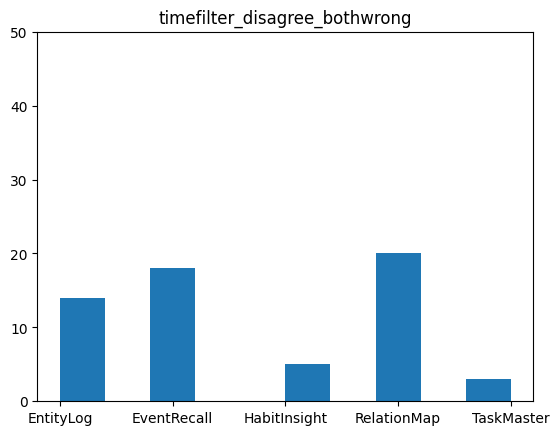

In [10]:
toplot = [e for e in egolife_qa_jake if e['ID'] in bothwrong['ID'].values]
config = 'timefilter_disagree_bothwrong'

# --- Visualization ---
import matplotlib.pyplot as plt

types = [e['type'] for e in toplot]
plt.hist(sorted(types))
plt.ylim(0, 50)
plt.title(config)
plt.savefig(f'{config}.png')
plt.show()

### Get query_time of all wrong predictions where both agree. 
Focus on 1-3 hours with most examples to play around with entity graph building (only DT, DT + captions) and check what works best

In [29]:
import numpy as np 

incorr_agree_qa = [e for e in egolife_qa_jake if e['ID'] in incorrect_agreements['ID'].values]

days, counts = np.unique(([e['query_time']['date'] for e in incorr_agree_qa]), return_counts=True)
print(days)
print(counts)

['DAY1' 'DAY2' 'DAY3' 'DAY4' 'DAY5' 'DAY6' 'DAY7']
[30 13 24 17 23 18  7]


In [46]:
for day in [f'DAY{i+1}' for i in range(7)]:
    i, c = np.unique([e['query_time']['time'][:2] for e in incorr_agree_qa if e['query_time']['date']==day], return_counts=True)
    
    print()
    idx = np.argsort(c)[::-1]
    print(f'{day}: hour={i[idx]}, count={c[idx]}')
# print(day, i[idx], c[idx])

# Pick DAY1 hour 1 and 2, DAY3 hour 1, DAY5 hour 1


DAY1: hour=['19' '21' '13' '17' '12' '14' '11' '18'], count=[9 7 5 2 2 2 2 1]

DAY2: hour=['21' '18' '11' '12'], count=[7 3 2 1]

DAY3: hour=['16' '11' '15' '22' '21' '20' '17' '19' '18' '12'], count=[6 4 3 2 2 2 2 1 1 1]

DAY4: hour=['11' '12' '21' '10' '18' '15' '16' '17' '13'], count=[5 3 2 2 1 1 1 1 1]

DAY5: hour=['16' '18' '15' '20' '21' '12'], count=[7 5 4 4 2 1]

DAY6: hour=['10' '22' '21' '13' '16' '20' '15' '12' '11' '09'], count=[4 3 3 2 1 1 1 1 1 1]

DAY7: hour=['18' '17' '15' '13' '12' '11'], count=[2 1 1 1 1 1]


## qualitatively examine agent justifications

In [107]:
print(onecorrect.columns)
eventrecall_ids = [e['ID'] for e in egolife_qa_jake if e['type']=='EventRecall']

Index(['ID', 'question_with', 'options_with', 'answer_with', 'plan_with',
       'plan_relevant_context_with', 'mcq_prediction_with',
       'justification_with', 'question_without', 'options_without',
       'answer_without', 'plan_without', 'plan_relevant_context_without',
       'mcq_prediction_without', 'justification_without'],
      dtype='object')


In [116]:
onecorrect_ids = [i for i in onecorrect['ID'].values if i in eventrecall_ids]
print(len(onecorrect_ids)) # 32 eventrecall failure, 42 entitylog failure
bs = 5

b = 0

batch_ids = onecorrect_ids[b*bs:(b+1)*bs]

for idx in batch_ids:
    time_filter_entry = [e for e in results_with_timefilter if e['ID']==idx][0]
    notime_filter_entry = [e for e in results_without_timefilter if e['ID']==idx][0]
    options = time_filter_entry['options'].replace("\n", "; ")
    
    print(f"Question: {time_filter_entry['question']}\nOptions: {options}\nAnswer: {time_filter_entry['answer']}")
    print('WITH FILTER JUSTIFICATION: ', time_filter_entry['justification'])
    print('WITHOUT FILTER JUSTIFICATION: ', notime_filter_entry['justification']) ; print()

32
Question: Katrina is now suggesting dancing, what other activities has she suggested before?
Options: A.Pressed flowers; B.Suggested collecting leaves to make bookmarks; C.Made food; D.Made paper puppies
Answer: B
WITH FILTER JUSTIFICATION:  The context provides detailed evidence that Katrina suggested several creative and eco-friendly activities before dancing. Specifically, in the segment starting at 11:33:48, Katrina suggests 'making pressed flowers,' 'creating postcards and greeting cards,' 'arranging leaves and flowers into pictures,' and 'making bookmarks.' Among the options, Option B ('Suggested collecting leaves to make bookmarks') directly matches the activity described in the context: Katrina suggested collecting leaves and making bookmarks as a group craft activity. Option A ('Pressed flowers') is also mentioned, but the question asks for 'other activities' and the most specific match to the options is B, which combines both the collecting leaves and making bookmarks, as 

In [113]:
print(time_filter_entry['options'])

A.Grocery group and alcohol group; B.Grocery group and daily necessities group; C.Grocery group and snacks group; D.Daily necessities group and alcohol group


In [84]:
print(results_with_timefilter[0].keys())

dict_keys(['ID', 'question', 'options', 'answer', 'plan', 'plan_relevant_context', 'mcq_prediction', 'justification'])
